In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
import os 

In [ ]:
batch_size = 64

data_dir = os.path.join('/mnt', 'disks', 'disk-1', 'data')
csv_dir = os.path.join('data', 'CSVs')
models_dir = os.path.join(data_dir, 'models')
csv_path = {
    'train': os.path.join(csv_dir, 'tiles_train.csv'),
    'validation': os.path.join(csv_dir, 'tiles_validation.csv'),
    'test': os.path.join(csv_dir, 'tiles_test.csv'),
}

img_path = os.path.join(data_dir,
                        'tiles')

image_classes = ['cored','diffuse','CAA']

In [13]:
current_module = sys.modules[__name__]
csvs = ['tiles_train', 'tiles_validation', 'tiles_test']
for csv in csvs:
    print('loading {}'.format(csv))
    df_name = csv.split('_')[-1]
    setattr(current_module, df_name, pd.read_csv(os.path.join('data', 'CSVs', '{}.csv'.format(csv))))
    df = getattr(current_module, df_name)
    print(df.shape)
    display(df.head(2))
    
train_n_validation = pd.concat([train, validation])[['imagename'] + image_classes]   
assert train_n_validation.shape[0] == (train.shape[0] + validation.shape[0])
display(train_n_validation)

loading tiles_train
(155239, 8)


,id,imagename,cored,diffuse,CAA,negative,flag,notsure
0,10748,NA4757-02_AB/NA4757-02_AB_18_25_61.jpg,1.0,0.000000,0.0,0.0,0.0,0.0
1,29503,NA4918-02_AB17-24/NA4918-02_AB17-24_9_18_12.jpg,0.0,2.832462,0.0,0.0,0.0,0.0


loading tiles_validation
(8630, 8)


,id,imagename,cored,diffuse,CAA,negative,flag,notsure
0,0,NA_4896_02_AB17-24/neg_NA_4896_02_AB17-24_0_10...,0.0,0.0,0.0,1.0,0.0,0.0
1,0,NA_4896_02_AB17-24/neg_NA_4896_02_AB17-24_0_18...,0.0,0.0,0.0,1.0,0.0,0.0


loading tiles_test
(10873, 8)


,id,imagename,cored,diffuse,CAA,negative,flag,notsure
0,14,NA4053-02_AB/NA4053-02_AB_18_18.jpg_0.jpg,0.0,3.003472,0.0,0.0,0.28125,1.0
1,15,NA4053-02_AB/NA4053-02_AB_18_18.jpg_1.jpg,0.0,5.214052,0.0,0.0,2.00000,1.0


,imagename,cored,diffuse,CAA
0,NA4757-02_AB/NA4757-02_AB_18_25_61.jpg,1.0,0.000000,0.0
1,NA4918-02_AB17-24/NA4918-02_AB17-24_9_18_12.jpg,0.0,2.832462,0.0
2,NA4885-02_AB17-24/NA4885-02_AB17-24_4_23_50.jpg,1.0,1.000000,0.0
3,NA4749-02_AB/NA4749-02_AB_17_12_50.jpg,0.0,3.770270,0.0
4,NA4751-02_AB/NA4751-02_AB_19_6_34.jpg,0.0,1.000000,2.0
...,...,...,...,...
8625,NA_4933_02_AB17-24/neg_NA_4933_02_AB17-24_9_19...,0.0,0.000000,0.0
8626,NA_4933_02_AB17-24/neg_NA_4933_02_AB17-24_9_27...,0.0,0.000000,0.0
8627,NA_4933_02_AB17-24/NA_4933_02_AB17-24_9_3_1.jpg,0.0,1.000000,0.0
8628,NA_4933_02_AB17-24/neg_NA_4933_02_AB17-24_9_3_...,0.0,0.000000,0.0


In [14]:
threshold = .99
for class_i in image_classes:
    train_n_validation[class_i] = train_n_validation[class_i].map(lambda x: class_i if x >= threshold else '')

train_n_validation['label'] = train_n_validation['cored']  + ' ' + train_n_validation['diffuse']  + ' ' + train_n_validation['CAA'] 
train_n_validation['label'] = train_n_validation['label'].map(lambda x: x.strip() if x.strip() else 'negative')
train_n_validation.drop(columns=image_classes, inplace=True)
train_n_validation

,imagename,label
0,NA4757-02_AB/NA4757-02_AB_18_25_61.jpg,cored
1,NA4918-02_AB17-24/NA4918-02_AB17-24_9_18_12.jpg,diffuse
2,NA4885-02_AB17-24/NA4885-02_AB17-24_4_23_50.jpg,cored diffuse
3,NA4749-02_AB/NA4749-02_AB_17_12_50.jpg,diffuse
4,NA4751-02_AB/NA4751-02_AB_19_6_34.jpg,diffuse CAA
...,...,...
8625,NA_4933_02_AB17-24/neg_NA_4933_02_AB17-24_9_19...,negative
8626,NA_4933_02_AB17-24/neg_NA_4933_02_AB17-24_9_27...,negative
8627,NA_4933_02_AB17-24/NA_4933_02_AB17-24_9_3_1.jpg,diffuse
8628,NA_4933_02_AB17-24/neg_NA_4933_02_AB17-24_9_3_...,negative


In [15]:
train_n_validation.to_csv(os.path.join(img_path, 'train_v2.csv'), index=False)

In [16]:
df = pd.read_csv(os.path.join(img_path, 'train_v2.csv'))
display(df)
print(df.columns)
df.iloc[0:3].label.values

,imagename,label
0,NA4757-02_AB/NA4757-02_AB_18_25_61.jpg,cored
1,NA4918-02_AB17-24/NA4918-02_AB17-24_9_18_12.jpg,diffuse
2,NA4885-02_AB17-24/NA4885-02_AB17-24_4_23_50.jpg,cored diffuse
3,NA4749-02_AB/NA4749-02_AB_17_12_50.jpg,diffuse
4,NA4751-02_AB/NA4751-02_AB_19_6_34.jpg,diffuse CAA
...,...,...
163864,NA_4933_02_AB17-24/neg_NA_4933_02_AB17-24_9_19...,negative
163865,NA_4933_02_AB17-24/neg_NA_4933_02_AB17-24_9_27...,negative
163866,NA_4933_02_AB17-24/NA_4933_02_AB17-24_9_3_1.jpg,diffuse
163867,NA_4933_02_AB17-24/neg_NA_4933_02_AB17-24_9_3_...,negative


Index(['imagename', 'label'], dtype='object')


array(['cored', 'diffuse', 'cored diffuse'], dtype=object)

In [17]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [18]:
np.random.seed(42)
src = (ImageList.from_csv(img_path, 'train_v2.csv', folder='all')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [19]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

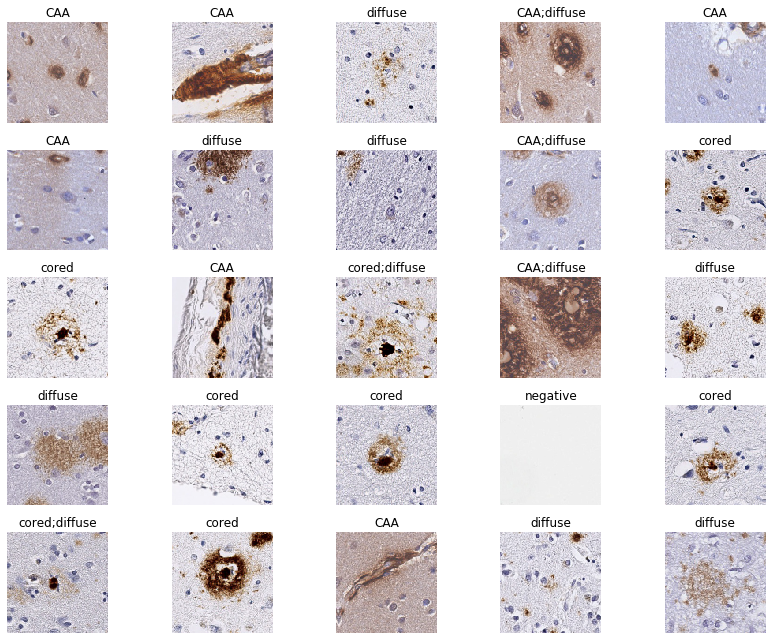

In [20]:
data.show_batch(rows=5, figsize=(12,9))

In [21]:
resnet34 = models.resnet34

In [22]:
acc_05 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, resnet34, metrics=[acc_05, f_score])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jupyter/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 109MB/s] 


In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


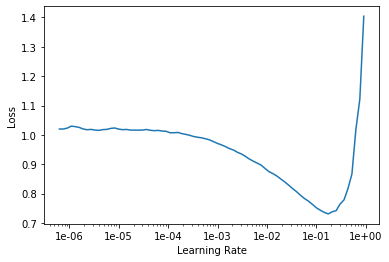

In [24]:
learn.recorder.plot()

In [25]:
lr = 0.01

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.149253,0.131466,0.948805,0.915772,02:50
1,0.131222,0.120864,0.952492,0.926059,02:53
2,0.111407,0.097514,0.962652,0.940771,02:54


In [ ]:
learn.save(os.path.join(models_dir, 'stage-1-rn34'))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.most_confused()

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

In [ ]:
learn.save('stage-2-rn34')